In [1]:
import numpy as np  
import pandas as pd
from numpy import median, percentile
from numpy.random import seed, randint
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from scipy.integrate import cumtrapz
from sklearn.metrics import (roc_auc_score, cohen_kappa_score,confusion_matrix, precision_score,
                             accuracy_score, average_precision_score, f1_score,
                             precision_recall_curve, roc_curve) #, auc, recall_score)
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt              
from inspect import signature
import joblib
from sklearn.calibration import (CalibratedClassifierCV, 
                                 _CalibratedClassifier, calibration_curve)  
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (make_scorer, roc_auc_score) #, cohen_kappa_score,confusion_matrix, precision_score,
#                             accuracy_score, auc, average_precision_score, f1_score,
#                             precision_recall_curve, recall_score, roc_curve)          
import dill
import sys
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("./data/cleaned_df.csv", delimiter=",")

In [3]:
df

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean,ic9value,diagnosispriority,cardiotreatment
0,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
1,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
2,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
3,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
4,242895,Male,80,101.2,170.18,Caucasian,136.371429,73.028571,87.857143,cardiaca_otros,Primary,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4559,3352230,Male,41,127.0,177.80,African American,117.101449,65.260870,84.304348,cardiopatia_isquemica,Primary,True
4560,3352231,Male,41,127.0,177.80,African American,128.000000,71.800000,91.800000,cardiopatia_isquemica,Primary,True
4561,3352333,Male,72,68.3,177.80,Caucasian,146.600000,81.628571,106.228571,non_cardiovascular,unknown,False
4562,3353113,Male,50,88.0,188.00,Caucasian,136.022222,88.733333,107.511111,hipertension,Other,False


In [4]:
# Converting categorical variables to numeric
df.gender.loc[df.gender == 'Male'] = 1
df.gender.loc[df.gender == 'Female'] = 0

df.age.loc[df.age == '> 89'] = 89
df.age = df.age.astype(float)

df.ethnicity.loc[df.ethnicity == 'Caucasian'] = 0
df.ethnicity.loc[df.ethnicity == 'Native American'] = 1
df.ethnicity.loc[df.ethnicity == 'African American'] = 2
df.ethnicity.loc[df.ethnicity == 'Hispanic'] = 3
df.ethnicity.loc[df.ethnicity == 'Asian'] = 4
df.ethnicity.loc[df.ethnicity == 'Other/Unknown'] = 5

df.ic9value.loc[df.ic9value == 'cardiaca_otros'] = 0
df.ic9value.loc[df.ic9value == 'non_cardiovascular'] = 1
df.ic9value.loc[df.ic9value == 'hipertension'] = 0
df.ic9value.loc[df.ic9value == 'cardiopatia_isquemica'] = 2
df.ic9value.loc[df.ic9value == 'cerebrovascular'] = 3
df.ic9value.loc[df.ic9value == 'circulacion_pulmonar'] = 4
df.ic9value.loc[df.ic9value == 'arterios_capilares'] = 5
df.ic9value.loc[df.ic9value == 'cardiaca_reumatica_cronica'] = 6
df.ic9value.loc[df.ic9value == 'sistema_circulatorio'] = 7
df.ic9value.loc[df.ic9value == 'venas_linfaticos'] = 7

df.diagnosispriority.loc[df.diagnosispriority == 'Major'] = 0
df.diagnosispriority.loc[df.diagnosispriority == 'Other'] = 1
df.diagnosispriority.loc[df.diagnosispriority == 'unknown'] = 2
df.diagnosispriority.loc[df.diagnosispriority == 'Primary'] = 3

df.cardiotreatment.loc[df.cardiotreatment == True] = 1
df.cardiotreatment.loc[df.cardiotreatment == False] = 0


C:\Users\Núria\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
df.ic9value.value_counts()

0    2551
1     978
2     449
7     273
3     204
4      78
5      23
6       8
Name: ic9value, dtype: int64

In [6]:
df

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean,ic9value,diagnosispriority,cardiotreatment
0,242895,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
1,242895,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
2,242895,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
3,242895,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
4,242895,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4559,3352230,1,41.0,127.0,177.80,2,117.101449,65.260870,84.304348,2,3,1
4560,3352231,1,41.0,127.0,177.80,2,128.000000,71.800000,91.800000,2,3,1
4561,3352333,1,72.0,68.3,177.80,0,146.600000,81.628571,106.228571,1,2,0
4562,3353113,1,50.0,88.0,188.00,0,136.022222,88.733333,107.511111,0,1,0


Split data into x y training and x y test sets

In [7]:
df = df.drop(columns = ['patientunitstayid']) 
train, test = train_test_split(df, test_size=0.25, random_state=25)

y_train = train['cardiotreatment']
X_train = train.drop(columns = ['cardiotreatment'])

y_test = test['cardiotreatment']
X_test = test.drop(columns = ['cardiotreatment'])
   
y_train = y_train.astype('int')
y_test = y_test.astype('int')
# All    

X_num = X_train.drop(columns = ['gender','ethnicity', 'ic9value', 'diagnosispriority'])
#X_num = X_train.drop(columns = ['gender','ethnicity', 'diagnosispriority'])

get_numeric_data = FunctionTransformer(lambda x: x[X_num.columns], validate=False)

get_categorical = FunctionTransformer(lambda x: x[['gender','ethnicity', 'ic9value', 'diagnosispriority']], validate=False) 
#get_categorical = FunctionTransformer(lambda x: x[['gender','ethnicity','diagnosispriority']], validate=False) 

scaler = MinMaxScaler()


In [8]:
df

,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean,ic9value,diagnosispriority,cardiotreatment
0,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
1,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
2,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
3,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
4,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...
4559,1,41.0,127.0,177.80,2,117.101449,65.260870,84.304348,2,3,1
4560,1,41.0,127.0,177.80,2,128.000000,71.800000,91.800000,2,3,1
4561,1,72.0,68.3,177.80,0,146.600000,81.628571,106.228571,1,2,0
4562,1,50.0,88.0,188.00,0,136.022222,88.733333,107.511111,0,1,0


In [9]:
df.dtypes

gender                   object
age                     float64
admissionweight         float64
admissionheight         float64
ethnicity                object
noninvasivesystolic     float64
noninvasivediastolic    float64
noninvasivemean         float64
ic9value                 object
diagnosispriority        object
cardiotreatment          object
dtype: object

In [10]:
y_train.dtypes

dtype('int32')

In [11]:
X_train.dtypes

gender                   object
age                     float64
admissionweight         float64
admissionheight         float64
ethnicity                object
noninvasivesystolic     float64
noninvasivediastolic    float64
noninvasivemean         float64
ic9value                 object
diagnosispriority        object
dtype: object

Modeling

In [12]:
# Logistic Regression
lr = LogisticRegression(random_state = 42,tol=1**-4,verbose=1) #,solver='lbfgs') #,class_weight='balanced')

# Random forests
rf = RandomForestClassifier(random_state = 42
                            #,n_jobs =-1 # set The number of jobs to run in parallel -1 means using all processors
                           )

# Neural Network

nn = MLPClassifier(random_state = 42,max_iter=500)

# SVM

svm = SVC(random_state = 42,probability=True) # Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down that method.

# XGB

xgb = XGBClassifier(random_state = 42)

all_models_list = [lr,
                   rf,
                   nn,
                   svm,
                   xgb]

all_models_names = ['lr',
                    'rf',
                    'nn',
                    'svm',
                    'xgb']

#all_models_list = [rf]

#all_models_names = ['rf']

## Pipelines
These are the parameters we are going to pass to each model in the hyper-parameter tunning.

In [13]:
num_pipe = Pipeline([
  ('select_num', get_numeric_data),
  ('scale', scaler)
  ])

cat_pipe = Pipeline([
  ('select_cat', get_categorical)
  ])

# Logistic Regression
lr_params =  {'clf__C':[0.0001,0.001,0.01,0.1,1.0]
               , 'clf__solver':['newton-cg', 'lbfgs', 'sag', 'saga']
               , 'clf__warm_start':[True,False]}   

# Random forests      
rf_params =  {'clf__n_estimators':  [1000,1500],
               'clf__max_features': ['sqrt'],
               'clf__max_depth': [2,3,4,5],
               'clf__bootstrap': [True, False],
               'clf__criterion': ["gini"],
               'clf__warm_start':[True,False]
               #,'clf__oob_score':[True,False]
             }

# Neural Network    
nn_params =  {'clf__hidden_layer_sizes': [(10,10,10), (50,100,50), (100,20)],
               'clf__activation': ['tanh', 'relu'],
               'clf__solver': ['sgd', 'adam'],
               'clf__alpha': [0.0001, 0.05],
               'clf__learning_rate': ['constant','adaptive']}

# SVM    
svm_params =  {'clf__C': [1, 10, 100, 1000],
               'clf__gamma': [0.001, 0.0001],
               'clf__kernel': ['rbf','linear']} 

# XGB    
xgb_params =  {'clf__max_depth': [1,3,100],
               'clf__learning_rate': [0.1],
               'clf__n_estimators': [100,500,1000],
               'clf__silent': [True],
               'clf__objective': ['binary:logistic'],
               'clf__booster': ['gbtree'],
               'clf__n_jobs': [1],
               'clf__nthread': [None],
               'clf__gamma': [0],
               'clf__min_child_weight': [1],
               'clf__max_delta_step': [0],
               'clf__subsample': [1],
               'clf__colsample_bytree': [1],
               'clf__colsample_bylevel': [1],
               'clf__reg_alpha': [0,0.0001, 0.05, 0.5],
               'clf__reg_lambda': [0,1],
               'clf__scale_pos_weight': [1,53.22], # Controls the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sumnegative instances / sumpositive instances
               'clf__base_score': [0.5],
               'clf__random_state': [0],
               'clf__seed': [None]} 

all_params_list = [lr_params,
                    rf_params,
                    nn_params,
                    svm_params,
                    xgb_params
                  ]

#all_params_list = [rf_params
#                  ]

In [14]:
bestmodels = [] # we create an empty list to store the best performing version of each model

if len(all_models_list) == len(all_params_list):
    for i,model in enumerate(all_models_list):
        print(type(all_models_list[i]))
        full_pipeline = Pipeline([('feat_union',
                                   FeatureUnion(transformer_list=[('cat_pipeline', cat_pipe),('num_pipeline', num_pipe) ])),
                                  ('clf', model)])
    
        scoring = make_scorer(roc_auc_score, needs_threshold = True)
    
        random_search = RandomizedSearchCV(full_pipeline, param_distributions=all_params_list[i], n_iter=5, cv=5, refit = True, scoring=scoring, n_jobs=-1, verbose=10, random_state = 42)
    
        sys.setrecursionlimit(10000)
        random_search.fit(X_train, y_train) 
    
        # Best model in training
        bestmodels.append(random_search.best_estimator_)
    
else:
    print('Make sure the amount of models in all_models_list matches the amount of params in all_params_list')

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
bestmodels

[Pipeline(steps=[('feat_union',
                  FeatureUnion(transformer_list=[('cat_pipeline',
                                                  Pipeline(steps=[('select_cat',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000022459D769D8>))])),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('select_num',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224376DF168>)),
                                                                  ('scale',
                                                                   MinMaxScaler())]))])),
                 ('clf',
                  LogisticRegression(C=0.1, random_state=42, tol=1.0, verbose=1,
                                     warm_start=True))]),
 Pipeline(steps=[('feat_union',
                  FeatureUnion(tran

### Defining functions
Specificity and Sensitivity

In [15]:
def spec(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TN/(TN+FP)   

def sens(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TP/(TP+FN) 

Optimal AUC threshold

In [16]:
def optimal_threshold_auc(target, predicted):
 
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

AUROC

In [17]:
def auroc(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    fpr, tpr, thresholds = roc_curve(y, ypred)
    auc_score = roc_auc_score(y, ypred)

    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr, tpr, marker='.',color='c')
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('Recall')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUROC={0:0.2f}'.format(auc_score)) 
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

AUPR

In [18]:
def aupr(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    Baseline = sum(y)/len(y)
    average_precision = metrics.average_precision_score(y, ypred)
    
    precision, recall, _ = precision_recall_curve(y, ypred)
    auc = metrics.auc(recall, precision)
    step_kwargs = ({'step': 'post'}
    if 'step' in signature(pyplot.fill_between).parameters
    else {})
    pyplot.step(recall, precision, color='c', where='post')
    pyplot.fill_between(recall, precision, color='c', **step_kwargs)
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUPRC={0:0.2f}'.format(auc))
#    pyplot.plot(Baseline, 'b-',label='Baseline')
#    pyplot.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0., fontsize = 16)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 
        
        
def metric_aupr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc = metrics.auc(recall, precision)
    return auc        

Bootstrapping function

In [19]:
def metric_SMR(y_true, y_pred):
   SMR = sum(y_pred)/sum(y_true)
   return SMR

def get_CI_boot(y_true,y_pred,metric,boot):
    # bootstrap confidence intervals
    # seed the random number generator
    seed(1)
    i = 0
    # generate dataset
    dataset = y_pred
    real = y_true
    # bootstrap
    scores = list()
    while i < boot:
        # bootstrap sample
        indices = randint(0, len(y_pred) - 1, len(y_pred))
        sample = dataset[indices]
        real = y_true[indices]
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
    	# calculate and store statistic 
        else:
            statistic = metric(real,sample)
            scores.append(statistic)
            i += 1
    
    # calculate 95% confidence intervals (100 - alpha)
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(scores, lower_p))
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    if metric == metric_SMR:
        upper = percentile(scores, upper_p)
    else:
        upper = min(1.0, percentile(scores, upper_p))
    delta = upper-lower
    mediana = median(scores)
    return mediana,(lower,upper),delta

### Predictions in train and test
Insights, AUPR and AUROC curves

lr


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.68 CI [0.65-0.72], precision_score 0.92 CI [0.9-0.94], spec 0.67 CI [0.63-0.75], sens 0.65 CI [0.63-0.68]]
rf


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.88 CI [0.85-0.91], precision_score 0.96 CI [0.95-0.97], spec 0.82 CI [0.77-0.87], sens 0.85 CI [0.83-0.87]]


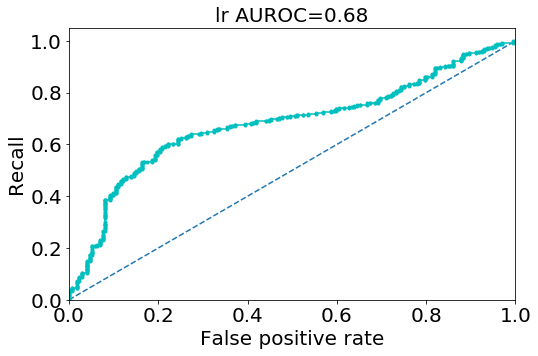

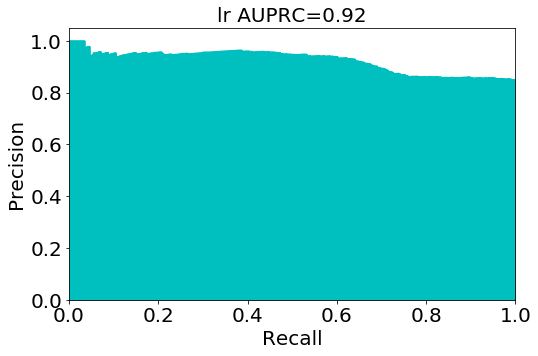

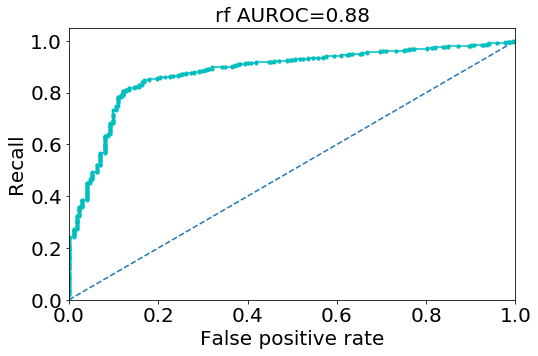

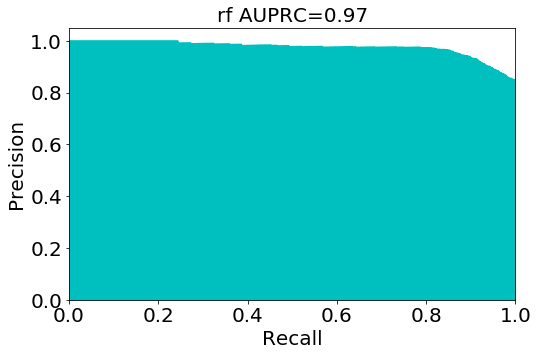

In [20]:
for i,model in enumerate(bestmodels):
    modelname = all_models_names[i]
    print(modelname)
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    auroc(y_test, y_test_pred,all_models_names[i])
    aupr(y_test, y_test_pred,all_models_names[i])
    # Threshold in train
    threshold = optimal_threshold_auc(y_train, y_train_pred)
    
   # performance_all = [roc_auc_score,average_precision_score, accuracy_score, spec, 
   #                sens, precision_score, f1_score, cohen_kappa_score,metric_SMR,metric_aupr] 
   # 
   # performance_names_all = np.array(['roc_auc_score','average_precision_score'
   #                               ,' accuracy_score',' spec','sens',' precision_score'
   #                               ,' f1_score',' cohen_kappa_score','metric_SMR','metric_aupr'])
   # 
    performance = [roc_auc_score,precision_score, spec, sens] 
    
    performance_names = np.array(['roc_auc_score','precision_score','spec','sens'])
    
    
    conf = []
    delt = []
    met = []
    med = []
    te = []
    performance_insights = []
    
    y_test = np.array(y_test)
    
    for i,p in enumerate(performance):
        
        if (p == roc_auc_score or p == average_precision_score or p == metric_aupr):
            mediana,extremes,delta = get_CI_boot(y_test,y_test_pred,p,boot=100) #atencao aqui ao boot
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_test_pred)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_test_pred), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
        else:
            y_pred_threshold = (y_test_pred >= threshold).astype(np.int)
            mediana,extremes,delta = get_CI_boot(y_test,y_pred_threshold,p,boot=100)
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_pred_threshold)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_pred_threshold), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
            
    
    performance_insights =  str(performance_insights)
    performance_insights = performance_insights.replace("'", "")
    print(performance_insights)    

Save results

In [21]:

db_name = 'OR'


# XGB
model_name = 'XGB'

features_name = 'full'


# Best model
filename = '{}_{}_{}_model.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search.best_estimator_, pickle_file)
    print('model saved')
    
# CV model
filename = '{}_{}_{}model_CV.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search, pickle_file)
    print('model saved') 

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

### Explanability of the model

In [22]:
model= LogisticRegression(C=0.1, random_state=42, tol=1.0, verbose=1,
                                     warm_start=True)
model.fit(X_train, y_train)

print(model.coef_[0])


[-0.05222117  0.02734358  0.00775879  0.00187655  0.08634445  0.01121901
  0.03722849 -0.05067139  0.00897415 -0.45883274]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [23]:
print(model.intercept_)

[0.01037664]


In [24]:
pd.DataFrame(model.coef_[0], X_train.columns, columns = ['Coeff'])

,Coeff
gender,-0.052221
age,0.027344
admissionweight,0.007759
admissionheight,0.001877
ethnicity,0.086344
noninvasivesystolic,0.011219
noninvasivediastolic,0.037228
noninvasivemean,-0.050671
ic9value,0.008974
diagnosispriority,-0.458833
